In [17]:
# GA ANN Model with PyGAD
# pip install pygad
# https://github.com/ahmedfgad/NeuralGenetic/blob/master/example_regression.py
from pandas import read_csv
import pandas_datareader.data as wb
from datetime import datetime

# load dataset
def get_data_from_api(ticker, start_date, end_date):
    dataframe = wb.DataReader(ticker, 'yahoo', start_date, end_date)
    return dataframe

start = datetime(2021,1,1)
end = datetime(2021,5,1)
tickerList = 'MSFT'
df = get_data_from_api(tickerList, start, end)
df = df[['Close']]

# split into train and test sets
X = df.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
# create lists for use with PyGAD
train = [x[0] for x in train]
test = [x[0] for x in test]

Generation = 1
Fitness    = 0.004086142519456766
Change     = 0.004086142519456766
Generation = 2
Fitness    = 0.004022400870381188
Change     = -6.374164907557798e-05
Generation = 3
Fitness    = 0.004022400870381188
Change     = 0.0
Generation = 4
Fitness    = 0.00417643218645717
Change     = 0.00015403131607598201
Generation = 5
Fitness    = 0.00417643218645717
Change     = 0.0
Generation = 6
Fitness    = 0.00417643218645717
Change     = 0.0
Generation = 7
Fitness    = 0.00417643218645717
Change     = 0.0
Generation = 8
Fitness    = 0.004299795633536936
Change     = 0.00012336344707976604
Generation = 9
Fitness    = 0.004335123930016831
Change     = 3.532829647989472e-05
Generation = 10
Fitness    = 0.004921598409734128
Change     = 0.0005864744797172972
Generation = 11
Fitness    = 0.004921598409734128
Change     = 0.0
Generation = 12
Fitness    = 0.004921598409734128
Change     = 0.0
Generation = 13
Fitness    = 0.004921598409734128
Change     = 0.0
Generation = 14
Fitness    = 0.0

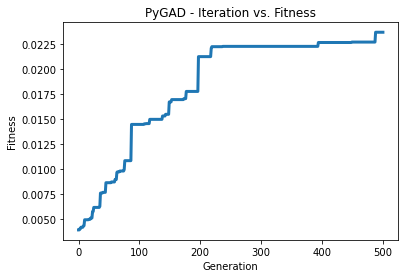

In [18]:
import numpy
import pygad
import pygad.nn
import pygad.gann

def fitness_func(solution, sol_idx):
    global GANN_instance, data_inputs, data_outputs

    predictions = pygad.nn.predict(last_layer=GANN_instance.population_networks[sol_idx],
                                   data_inputs=data_inputs, problem_type="regression")
    solution_fitness = 1.0/numpy.mean(numpy.abs(predictions - data_outputs))

    return solution_fitness

def callback_generation(ga_instance):
    global GANN_instance, last_fitness

    population_matrices = pygad.gann.population_as_matrices(population_networks=GANN_instance.population_networks, 
                                                            population_vectors=ga_instance.population)

    GANN_instance.update_population_trained_weights(population_trained_weights=population_matrices)

    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution()[1] - last_fitness))

    last_fitness = ga_instance.best_solution()[1].copy()

# Holds the fitness value of the previous generation.
last_fitness = 0

# Preparing the NumPy array of the inputs.
data_inputs = numpy.array([train])

# Preparing the NumPy array of the outputs.
data_outputs = numpy.array([test])

# The length of the input vector for each sample (i.e. number of neurons in the input layer).
num_inputs = data_inputs.shape[1]

# Creating an initial population of neural networks. The return of the initial_population() function holds references to the networks, not their weights. Using such references, the weights of all networks can be fetched.
num_solutions = 6 # A solution or a network can be used interchangeably.
GANN_instance = pygad.gann.GANN(num_solutions=num_solutions,
                                num_neurons_input=num_inputs,
                                num_neurons_hidden_layers=[2],
                                num_neurons_output=len(test),
                                hidden_activations=["relu"],
                                output_activation="None")

# population does not hold the numerical weights of the network instead it holds a list of references to each last layer of each network (i.e. solution) in the population. A solution or a network can be used interchangeably.
# If there is a population with 3 solutions (i.e. networks), then the population is a list with 3 elements. Each element is a reference to the last layer of each network. Using such a reference, all details of the network can be accessed.
population_vectors = pygad.gann.population_as_vectors(population_networks=GANN_instance.population_networks)

# To prepare the initial population, there are 2 ways:
# 1) Prepare it yourself and pass it to the initial_population parameter. This way is useful when the user wants to start the genetic algorithm with a custom initial population.
# 2) Assign valid integer values to the sol_per_pop and num_genes parameters. If the initial_population parameter exists, then the sol_per_pop and num_genes parameters are useless.
initial_population = population_vectors.copy()

num_parents_mating = 4 # Number of solutions to be selected as parents in the mating pool.

num_generations = 500 # Number of generations.

mutation_percent_genes = 5 # Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists.

parent_selection_type = "sss" # Type of parent selection.

crossover_type = "single_point" # Type of the crossover operator.

mutation_type = "random" # Type of the mutation operator.

keep_parents = 1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.

init_range_low = -1
init_range_high = 1

ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       mutation_percent_genes=mutation_percent_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       keep_parents=keep_parents,
                       on_generation=callback_generation)

ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_result()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

# Predicting the outputs of the data using the best solution.
predictions = pygad.nn.predict(last_layer=GANN_instance.population_networks[solution_idx],
                               data_inputs=data_inputs,
                               problem_type="regression")
print("Predictions of the trained network : {predictions}".format(predictions=predictions))

# Calculating some statistics
abs_error = numpy.mean(numpy.abs(predictions - data_outputs))
print("Absolute error : {abs_error}.".format(abs_error=abs_error))

